# JWST light curve from rateint.fits file


## Dataset Description
### The following datset are from jwst NIRSEPC BOTS data 

#### Dataset available at https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

In [148]:
from astropy.io import fits
import numpy as np

##### Countrate products are produced by applying the ramp_fitting step to the integrations within an exposure, in order to compute count rates from the original accumulating signal ramps. For exposures that contain multiple integrations (NINTS > 1) this is done in two ways, which results in two separate products. First, countrates are computed for each integration within the exposure, the results of which are stored in a rateints product. These products contain 3-D data arrays, where each plane of the data cube contains the countrate image for a given integration

##### for more information visit the site https://jwst-pipeline.readthedocs.io/en/stable/jwst/data_products/science_products.html

##### Rateint int comes from stage 1 processing of uncall data. These data come from single exposures and are usually contained within a single FITS file. However, when the raw data volume for an individual exposure is large enough, like for time-series observations, the uncalibrated data can be broken into multiple segments less than 2GB each, so as to keep total file sizes to a reasonable level. Such broken-up exposures usually include "segNNN" in the file names, where NNN is 1-indexed and always includes any leading zeros https://jwst-docs.stsci.edu/accessing-jwst-data/jwst-science-data-overview

In [149]:
#since jwst ligth curve are segmeneted
Required_files = [
    "jw01366003001_04101_00001-seg001_nrs2_rateints.fits",
    "jw01366003001_04101_00001-seg002_nrs2_rateints.fits",
    "jw01366003001_04101_00001-seg003_nrs2_rateints.fits"
]

##### Data Description
##### SCI: 3-D data array containing the pixel values, in units of DN/s. The first two dimensions are equal to the size of the detector readout, with the data from multiple integrations stored along the 3rd axis.

##### ERR: 3-D data array containing uncertainty estimates on a per-integration basis. These values are based on the combined VAR_POISSON and VAR_RNOISE data (see below), given as standard deviation.

##### DQ: 3-D data array containing DQ flags. Each plane of the cube corresponds to a given integration.

##### INT_TIMES: A table of beginning, middle, and end time stamps for each integration in the exposure.

##### VAR_POISSON: 3-D data array containing the per-integration variance estimates for each pixel, based on Poisson noise only.

##### VAR_RNOISE: 3-D data array containing the per-integration variance estimates for each pixel, based on read noise only.

##### ADSF: The data model meta data.

In [150]:
#check data 
file_to_check = Required_files[0]
hdul = fits.open(file_to_check)
hdul.info()

Filename: jw01366003001_04101_00001-seg001_nrs2_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     249   ()      
  1  SCI           1 ImageHDU        63   (2048, 32, 155)   float32   
  2  ERR           1 ImageHDU        11   (2048, 32, 155)   float32   
  3  DQ            1 ImageHDU        12   (2048, 32, 155)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   155R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 32, 155)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 32, 155)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [8277B]   


In [151]:
file_to_check = Required_files[0]
hdul = fits.open(file_to_check)
hdul_dict = dict(hdul["SCI"].header)
hdul_dict

{'XTENSION': 'IMAGE',
 'BITPIX': -32,
 'NAXIS': 3,
 'NAXIS1': 2048,
 'NAXIS2': 32,
 'NAXIS3': 155,
 'PCOUNT': 0,
 'GCOUNT': 1,
 'EXTNAME': 'SCI',
 'MJD-BEG': 59790.91951388889,
 'MJD-AVG': 59791.09184913195,
 'MJD-END': 59791.264184375,
 'TDB-BEG': 59790.92023663242,
 'TDB-MID': 59791.09255526889,
 'TDB-END': 59791.26487390614,
 'XPOSURE': 29360.1,
 'TELAPSE': 29789.053,
 '': 
 JWST ephemeris information
 
 
 Information about the coordinates in the file
 
 
 Spacecraft pointing information
 
 
 WCS parameters,
 'REFFRAME': 'EME2000',
 'EPH_TYPE': 'Definitive',
 'EPH_TIME': 59791.09184913195,
 'JWST_X': 91815476.84790646,
 'JWST_Y': -111522899.1536672,
 'JWST_Z': -48731897.45675641,
 'OBSGEO-X': 545345099.5021366,
 'OBSGEO-Y': -1291929567.847113,
 'OBSGEO-Z': -978961274.49491,
 'JWST_DX': 23.21515156724432,
 'JWST_DY': 16.56018448588144,
 'JWST_DZ': 7.282985514766873,
 'OBSGEODX': 89.20175080884282,
 'OBSGEODY': -0.811047580746933,
 'OBSGEODZ': 103.5262274780199,
 'PA_APER': 247.526830

In [152]:
num_integration , x_dim , y_dim = hdul["SCI"].data.shape
print(f"y dim =  {y_dim}")
print(f"x dim = {x_dim}")
print(f"num_integration = {num_integration}")

hdul["SCI"].data[0][0]

y dim =  2048
x dim = 32
num_integration = 155


array([nan, nan, nan, ..., nan, nan, nan], dtype='>f4')

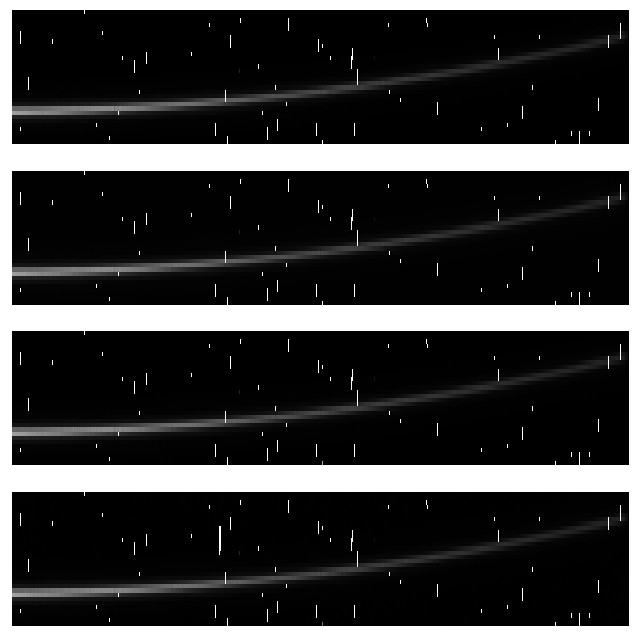

In [153]:
# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sl_fig, axs = plt.subplots(ncols=1, nrows=4, figsize=[8, 8])

for i, ax in enumerate(axs.flat):
    im = ax.imshow(hdul["SCI"].data[i, :, :], 
                   origin='lower', 
                   aspect='auto', 
                   interpolation='none',
                   cmap='grey')
    ax.axis("off")  

In [154]:
#concatenating all the data into a singal array
all_flux = []


# Loop through all segments
for file_name in Required_files:
    with fits.open(file_name) as hdul:
        ini_array = hdul["SCI"].data 
        data = np.where(np.isnan(ini_array), np.ma.array(ini_array, 
                   mask=np.isnan(ini_array)).mean(axis=0), ini_array)
        flux = np.nansum(data, axis=(1, 2)) 

        all_flux.extend(flux)

all_flux = np.array(all_flux)
all_flux[0:10] 

array([785604.62805836, 791037.98383455, 788787.22850215, 787035.34815956,
       792356.27529687, 790661.87443803, 787510.5756797 , 792994.97710949,
       793491.19394794, 789897.06129328])

In [155]:
#Time
time_check = fits.open(file_to_check)
time_arr = time_check["INT_TIMES"].data
print(time_arr[1][1:])
print(time_arr.shape) 

# Its is an 1d array with [num int,times (as listed below)]
# MJD-BEG
# MJD-AVG
# MJD-END
# TDB-BEG
# TDB-MID
# TDB-END

(59790.9201561958, 59790.920521705826, 59790.92088721585, 59790.92087887377, 59790.92124434857, 59790.92160982337)
(155,)


In [156]:
all_time = []
for file_name in Required_files:
    with fits.open(file_name) as hdul_time:
        time_lc = hdul_time["INT_TIMES"].data
        for i in range(time_lc.shape[0]):
            all_time.append(time_lc[i][1:][0])

all_time = np.array(all_time)

In [157]:
#verification since shape for time and flux should be same 
print(all_time.shape)
print(all_flux.shape)

(465,)
(465,)


In [158]:
from stingray import Lightcurve

lc = Lightcurve(all_time,all_flux)

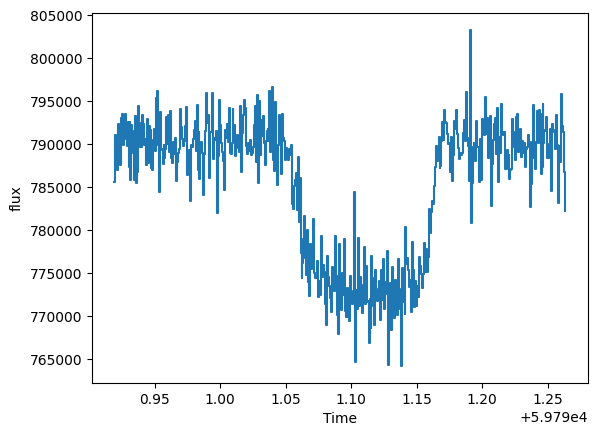

In [159]:
lc.plot(labels = ['Time','flux'])
plt.show()

### Lets use poisson regression to find the genral trend and smoothen it 


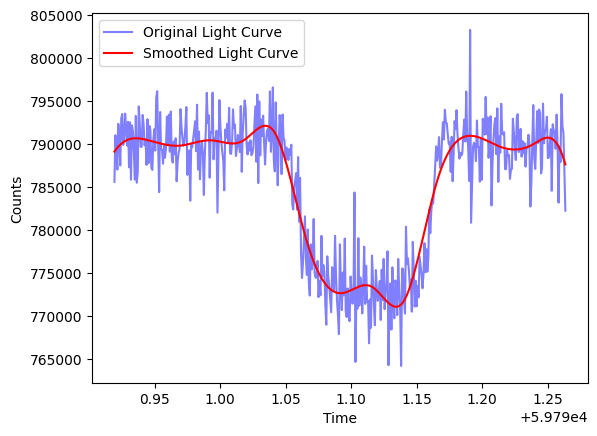

In [160]:
from Poissonregressor import smoothend_light_curve
lc_to_smothen = lc 
smoothed_lc = smoothend_light_curve(lc_to_smothen ,n_knots=15)
plt.plot(lc.time, lc.counts, label="Original Light Curve", color="blue",alpha=0.5)

# Plot smoothed light curve
plt.plot(smoothed_lc.time, smoothed_lc.counts, label="Smoothed Light Curve", color="red")


# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Counts")
plt.legend()
plt.show()

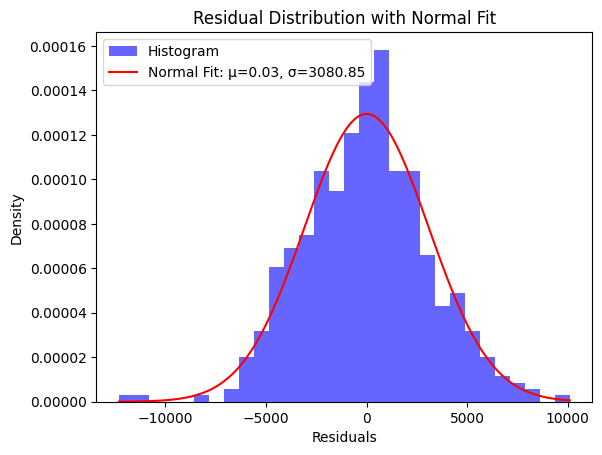

In [161]:

import matplotlib.pyplot as plt
from scipy.stats import norm

residuals = smoothed_lc.counts - lc.counts

mu, sigma = norm.fit(residuals)

plt.hist(residuals, bins=30, density=True, alpha=0.6, color='b', label="Histogram")

x = np.linspace(min(residuals), max(residuals), 100)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r-', label=f'Normal Fit: μ={mu:.2f}, σ={sigma:.2f}')

plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Residual Distribution with Normal Fit")
plt.legend()
plt.show()


## Now for spectroscopy i will use jwst pipeline

In [163]:
# from pipeline import process_spec2
# process_spec2(Required_files)
print("Extraction complete!!!")

Extraction complete!!!


## Now we use x1d int.fits file we will use that for our spectroscopic analysis that we got from the pipeline


In [164]:
extracted_files = [
    "extracted_x1d_int/jw01366003001_04101_00001-seg001_nrs2_x1dints.fits",
    "extracted_x1d_int/jw01366003001_04101_00001-seg002_nrs2_x1dints.fits",
    "extracted_x1d_int/jw01366003001_04101_00001-seg003_nrs2_x1dints.fits"
]

In [165]:
hdul_x1d = fits.open(extracted_files[0])
hdul_x1d[1]



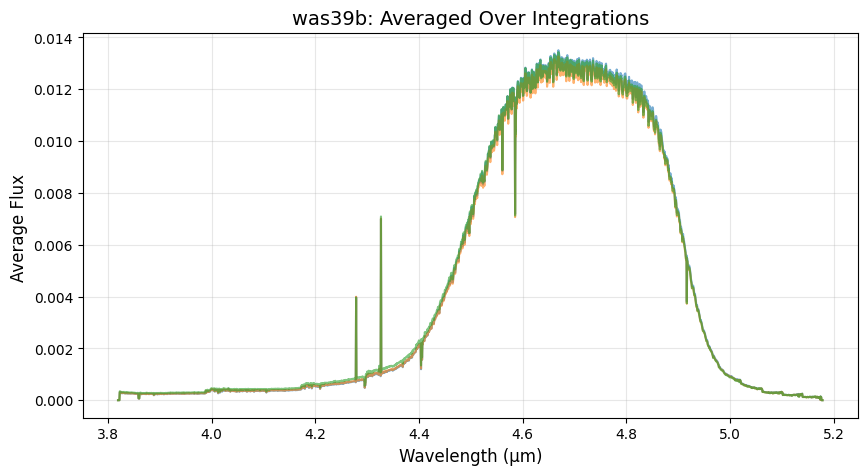

In [ ]:
#Now we will sum all the flux for their respective wavelength 

# Initialize the plot
plt.figure(figsize=(10, 5))

for file in extracted_files:
    with fits.open(file) as temp:

        wavlen = temp[2].data["WAVELENGTH"]
        
        summed_flux = np.zeros_like(temp[2].data["FLUX"])  

        for j in range(num_integration):  
            flux = temp[j + 2].data["FLUX"]  
            summed_flux = np.nansum([summed_flux, flux], axis=0)

        avg_flux = summed_flux / num_integration
        plt.plot(wavlen, avg_flux, alpha=0.6)

plt.xlabel("Wavelength (μm)", fontsize=12)
plt.ylabel("Average Flux ", fontsize=12)
plt.title("was39b: Averaged Over Integrations", fontsize=14)
plt.grid(alpha=0.3)


plt.show()
